Today, online reviews play a crucial role in shaping a business's reputation and success. As such, analyzing customer feedback has become increasingly important for companies across industries. In this notebook, I demonstrate my skills in natural language processing (NLP) and data analysis and show how different methods can help companies extract valuable insights from customer reviews.

By preprocessing and analyzing a dataset of customer reviews about Skincare products, I show how NLP techniques such as sentiment analysis and topic modeling can reveal trends and patterns that businesses can use to inform their decisions and strategies. These insights can help businesses enhance customer experience, identify areas for improvement, and drive revenue growth. 


# Table of content

Data download

Data preprocessing

- Text preprocessing

- Rating preprocessing

In-depth analysis

- Explore review length

- Rating/Sentiment distribution

- Most common words (unigrams)

- Bigrams

- Trigrams

Sentiment prediction

Topic modeling

Summary

# Data download

To begin, let's load all the necessary dependencies and dataset

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx

import re
import pickle
import string
from collections import Counter, defaultdict
import operator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Download dataset
! gdown ID --quiet

# Read dataset
df = pd.read_csv('/content/reviews_1500_end.csv', index_col=0)

Let's see what the dataframe looks like:

In [ ]:
with pd.option_context('display.max_colwidth', 20, 'display.max_columns', None):
    display(df.head())

,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,1945004256,5,1.0,0.000000,2,2,0,2022-12-10,I absolutely L-O...,A must have!,lightMedium,green,combination,NaN,P379064,Lotus Balancing ...,Clarins,65.0
1,5478482359,3,1.0,0.333333,3,2,1,2021-12-17,I gave this 3 st...,it keeps oily sk...,mediumTan,brown,oily,black,P379064,Lotus Balancing ...,Clarins,65.0
2,29002209922,5,1.0,1.000000,2,0,2,2021-06-07,Works well as so...,Worth the money!,lightMedium,brown,dry,black,P379064,Lotus Balancing ...,Clarins,65.0
3,7391078463,5,1.0,1.000000,2,0,2,2021-05-21,this oil helped ...,best face oil,lightMedium,brown,combination,blonde,P379064,Lotus Balancing ...,Clarins,65.0
4,1766313888,5,1.0,1.000000,13,0,13,2021-03-29,This is my first...,Maskne miracle,mediumTan,brown,combination,black,P379064,Lotus Balancing ...,Clarins,65.0


Since further analysis will focus on the text of the review and the customer rating, I will leave only the `'rating'` and `'review_text'` columns and rename them for simplicity. I will also check how many reviews have only a rating and have no review text 

In [ ]:
# Leave only meaningful columns for further work
df = df[['review_text', 'rating']].rename(columns={'review_text': 'review'})

In [ ]:
# Check number of rows where there is no review
df['review'].isnull().sum()

59

In [ ]:
# Drop all rows where there is no review
df = df.dropna(subset=['review'])

# Data preprocessing

## Text preprocessing

For further work, I need to preprocess the text:
- **clean** it up by getting rid of extraneous characters, punctuation, words with possible misprints, and 'stopwords' which do not add much meaning to a sentence
- **normalize** the text using the **lemmatization** technique that switches any kind of a word to its base root mode. For example, lemmatizing the word 'Caring' would return 'Care'

Below I have written a function that cleans and lemmatizes each review:

In [ ]:
def clean_text(text: str) -> str:
    """Cleans input text, tokenizes, removes stop words, and lemmatizes it"""

    # Remove digits, non-word/space characters, and consecutive repeating characters
    text = re.sub(r'\d+|[^\w\s]|\b(\w+)(\s+\1)+\b', '', text)

    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    # Tokenize, remove stop words, and lemmatize
    stop_words = set(stopwords.words('english'))
    tokens = (WordNetLemmatizer().lemmatize(w) 
              for w in word_tokenize(text) 
              if w not in stop_words and len(w) > 2)
    
    # Join tokens back into a single string
    text = ' '.join(tokens)

    return text

# Apply the new function and create a column with lemmatized text
df['lemma_text'] = df['review'].apply(clean_text)

# Create a column with a set of tokenized review words
df['NLTK_text'] = df['lemma_text'].apply(lambda x: nltk.Text(nltk.word_tokenize(x)))

# Show difference between original and lemmatized review
print('Original review \n', df['review'][27])
print('Lemmatized review \n', df['lemma_text'][27])

Original review 
 I have combination skin and have struggled with acne brake outs since my teens, I have always just reverted to products with harsh chemicals
Lemmatized review 
 combination skin struggled acne brake out since teen always reverted product harsh chemical


For clarity, I printed the above example of a review before and after cleaning. 


I added the cleaned reviews as a new column `'lemma_text'`, and added another one `'NLTK_text'` that contains each review as a sequence of words (tokens) in the `nltk.text.Text` wrapper.

In [ ]:
# Show dataframe with 2 new text columns
df.head(3)

,review,rating,lemma_text,NLTK_text
0,I absolutely L-O-V-E this oil. I have acne pro...,5,absolutely love oil acne prone skin use top ev...,"(absolutely, love, oil, acne, prone, skin, use..."
1,I gave this 3 stars because it give me tiny li...,3,gave star give tiny little white head first us...,"(gave, star, give, tiny, little, white, head, ..."
2,Works well as soon as I wash my face and pat d...,5,work well soon wash face pat dry smell amazing,"(work, well, soon, wash, face, pat, dry, smell..."


## Rating preprocessing

For machine learning, it is better to use simplified approaches to classifying ratings, and divide them into positive/negative or positive/neutral/negative.

Let's simplify the 5-point scale ratings and use some heuristics about how the rating represents sentiment:
- **rating > 3** is *positive*
- **rating = 3** is *neutral*
- **rating < 3** is *negative*

Let's create a new `'true_sentiment'` column:

In [ ]:
# Create a column with the verbal equivalent of a rating
df['true_sentiment'] = df['rating'].map({1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'})

# Show dataframe with new sentiment column
df.head(3)

,review,rating,lemma_text,NLTK_text,true_sentiment
0,I absolutely L-O-V-E this oil. I have acne pro...,5,absolutely love oil acne prone skin use top ev...,"(absolutely, love, oil, acne, prone, skin, use...",positive
1,I gave this 3 stars because it give me tiny li...,3,gave star give tiny little white head first us...,"(gave, star, give, tiny, little, white, head, ...",neutral
2,Works well as soon as I wash my face and pat d...,5,work well soon wash face pat dry smell amazing,"(work, well, soon, wash, face, pat, dry, smell...",positive


# In-depth analysis

## Explore review length

Let's analyze the main review length statistics below:
- half of the nearly 50k reviews are 259 characters long
- most reviews on average are between 178 and 403 characters long
- there are no one-word reviews, the minimum length is 20 characters, and the maximum length of the review is about one printed page of text

In [ ]:
df['length'] = df['review'].apply(len)
df['length'].describe().round(1)

count    49918.0
mean       324.6
std        242.4
min         20.0
25%        178.0
50%        259.0
75%        403.0
max       4416.0
Name: length, dtype: float64

Now let's find out if the rating affects the length of the customer review. I will draw a visualization of the length distribution of reviews based on the rating:

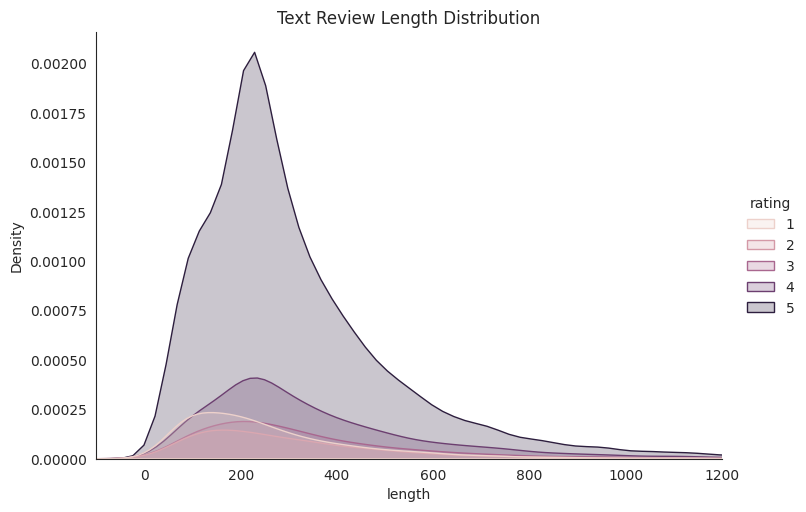

In [ ]:
sns.set_style('white')
(sns.displot(data=df, x='length', hue='rating', kind='kde', fill=True, aspect=1.5)
    .set(xlim=(-100, 1200), title='Text Review Length Distribution'));

As I can see, there is indeed a connection, and the lower the rating, the shorter the length of the review. Let's compare this in numbers:

In [ ]:
# Compare mean review length across ratings
grouped = df.groupby('rating')['length'].agg(mean_length='mean', count='count').reset_index().round(1)
grouped

,rating,mean_length,count
0,1,271.1,3921
1,2,308.8,2763
2,3,338.2,3760
3,4,360.1,7801
4,5,322.3,31673


As we can see, indeed, the length of the review is related to the rating - the lower the rating, the shorter the length of the review. Even given the quantitative prevalence of highly rated reviews, we can still observe this trend. 

## Rating/Sentiment distribution

Let's take a closer look at the distribution of feedback and sentiment in the dataset and visualize it.

First, let's visualize the distribution of the number of reviews by rating:

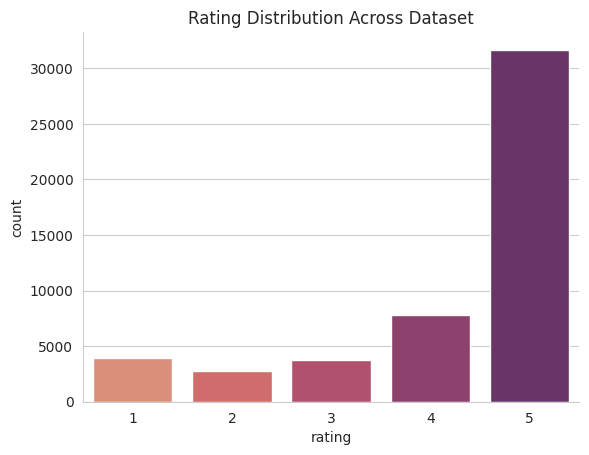

In [ ]:
sns.set_style('whitegrid')
sns.countplot(data=df, x='rating', palette='flare').set_title('Rating Distribution Across Dataset')
sns.despine()

There is an obvious imbalance in the number of reviews with different ratings. There are many more reviews with a 5-star rating than there are reviews with a low rating. You can also notice that there are almost equal numbers of 1, 2, or 3-star reviews. 

Let's look at how the reviews are distributed according to the distribution into positive/neutral/positive sentiment:

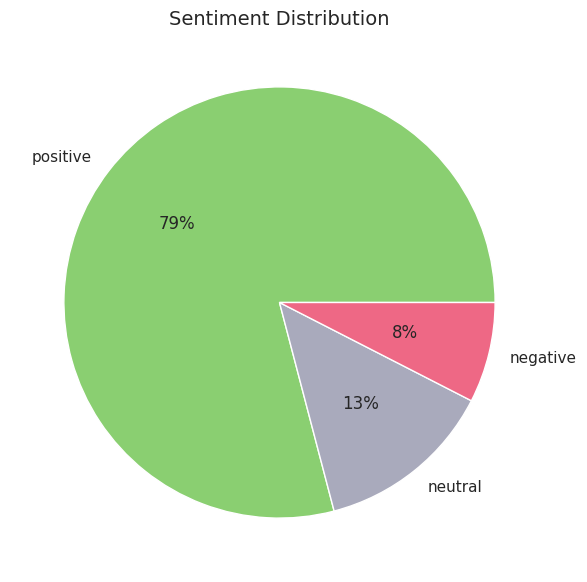

In [ ]:
# Define data and labels
data = df['true_sentiment'].value_counts()
labels = df['true_sentiment'].unique()

# Create pie chart
plt.figure(figsize=(7, 7))
plt.pie(data, labels=labels, colors=['#8ACF71', '#A9AABC', '#EE6885'], autopct='%.0f%%')
plt.title('Sentiment Distribution', fontsize=14);

About 80% of the reviews are positive, while only 8% are negative and 13% are neutral. We can conclude that customers prefer to leave mostly positive reviews

## Most common words (unigrams)

Below I visualize the most frequent words in reviews

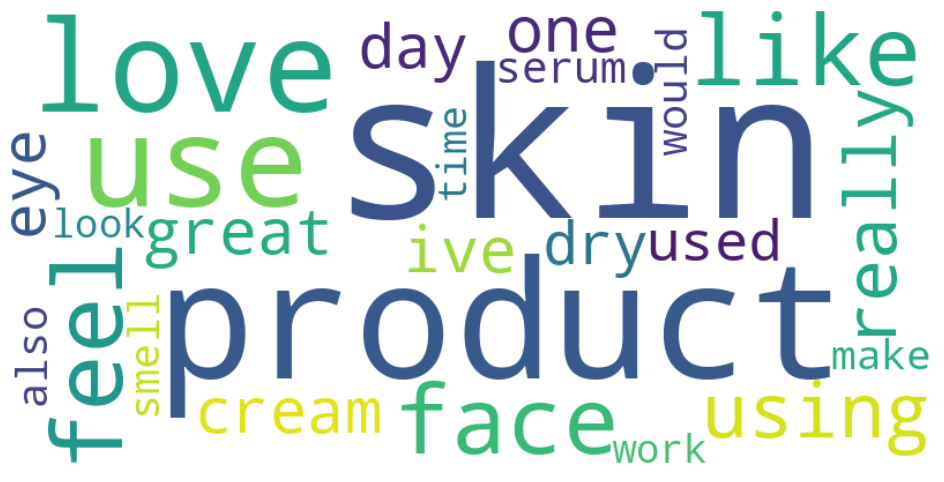

In [ ]:
top_words = Counter(' '.join(df['lemma_text']).split()).most_common(25)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

We see what we expect to see from this category of products - the central theme is skin + product, and then the words defining a positive experience. We also see words describing time and action.

Let's look at these values in figures:

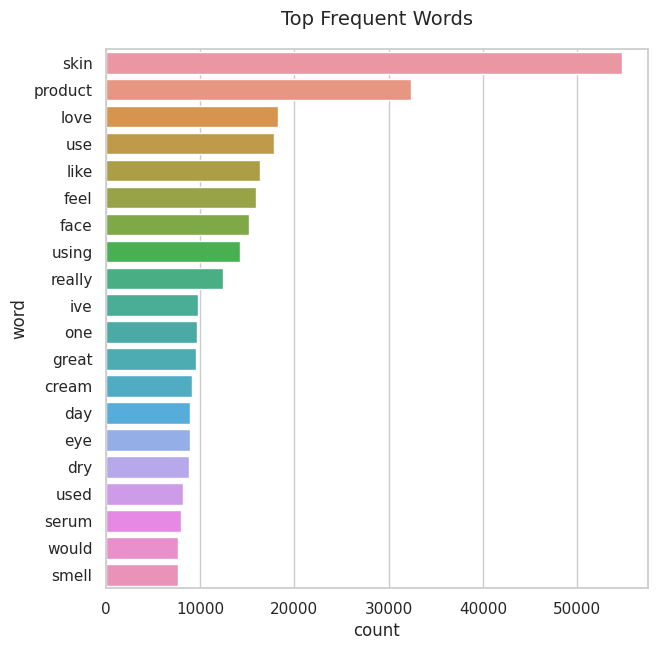

In [ ]:
# Convert the list of tuples into a pandas DataFrame
top_words = pd.DataFrame(top_words[:20], columns=['word', 'count'])

# Create a horizontal bar chart using Seaborn's barplot function
plt.figure(figsize=(7, 7))
sns.set(style="whitegrid")
sns.barplot(x="count", y="word", data=top_words)

# Add a title to the chart
plt.title('Top Frequent Words', fontsize=14, y=1.03);

## Bigrams

Before, I was looking at one word at a time (unigrams), but now I'm moving on to looking at pairs of words (bigrams). Bigrams give more context and therefore are more informative than single words.

Let's find combinations of the most frequent pairs of words using previously created column `'NLTK_text'` with word sequence:

In [ ]:
# Create list of sorted bigrams
bigrams = Counter()
for phrase in df['NLTK_text']:
    bigrams.update(nltk.bigrams(phrase))
    
bigrams_sorted = sorted(bigrams.items(), key=operator.itemgetter(1), reverse=True)

Below is a bar chart with the most frequent bigrams among all reviews

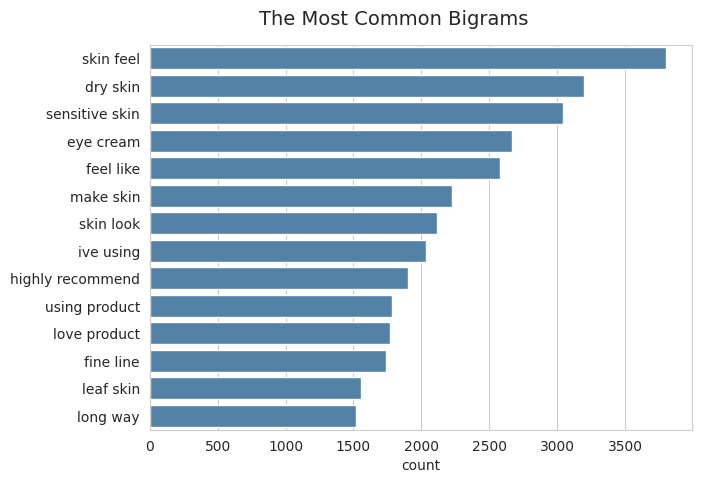

In [ ]:
# Visualize bigrams frequency
bigrams_df = pd.DataFrame(bigrams_sorted[:14], columns=['bigram', 'count'])

plt.figure(figsize=(7, 5))
sns.set_style('whitegrid')

sns.barplot(x='count', y=[' '.join(bigram) for bigram in bigrams_df['bigram']], data=bigrams_df, color='steelblue')

plt.xlabel('count')
plt.title('The Most Common Bigrams', fontsize=14, y=1.03, x=0.45);

Here we can observe a more interesting picture. We see that customers most often describe how their skin feels, and the most common problems are dryness and skin sensitivity.

I can explore in more depth the most common skin issues that bother customers, and also see how customers feel when they use different products. Let's present this as a network visualization for each feature (we well look at 6 in total):

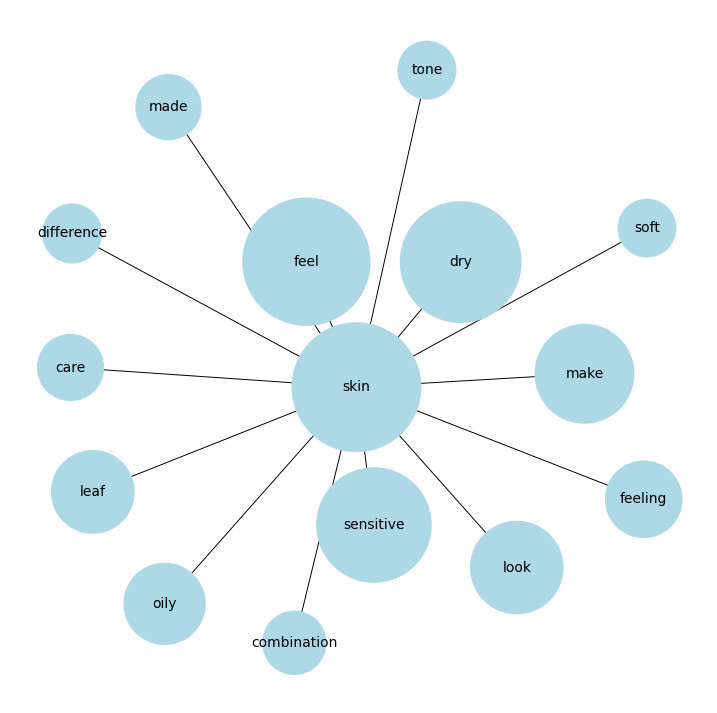

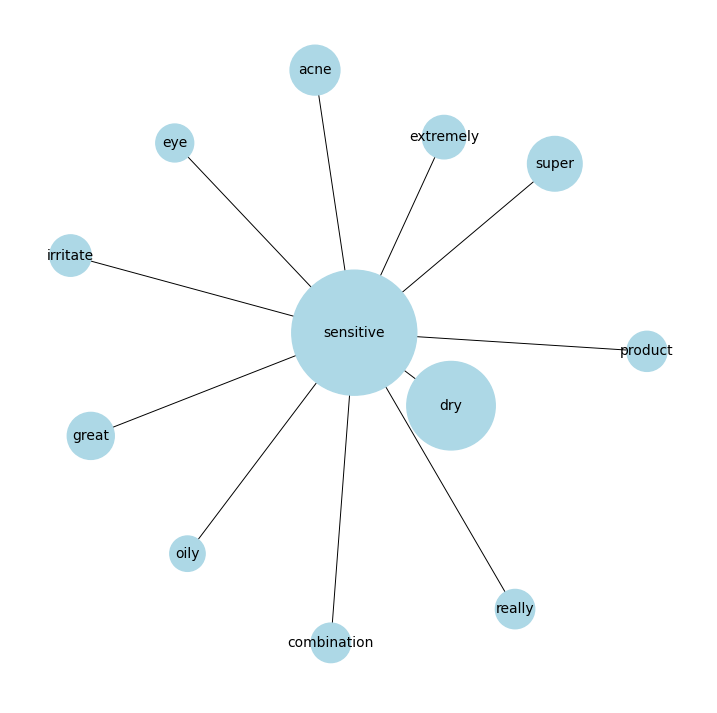

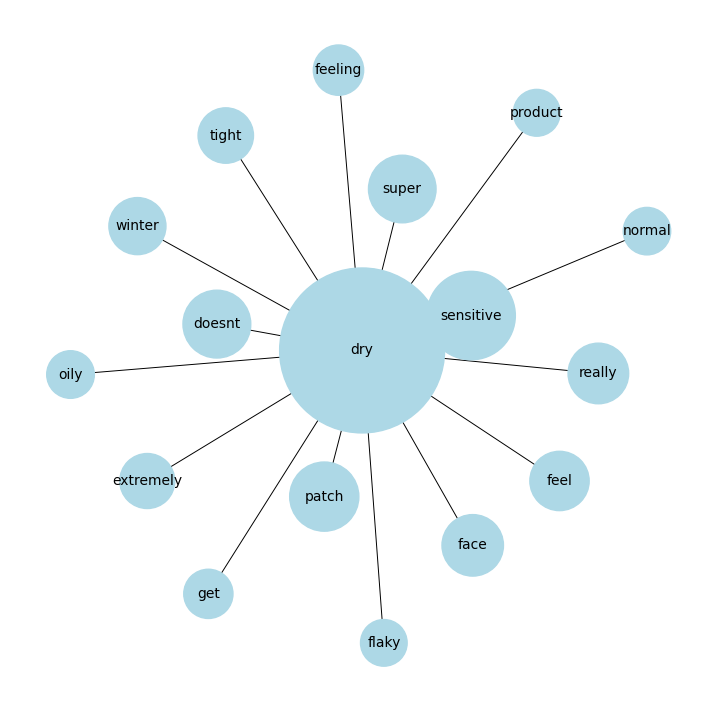

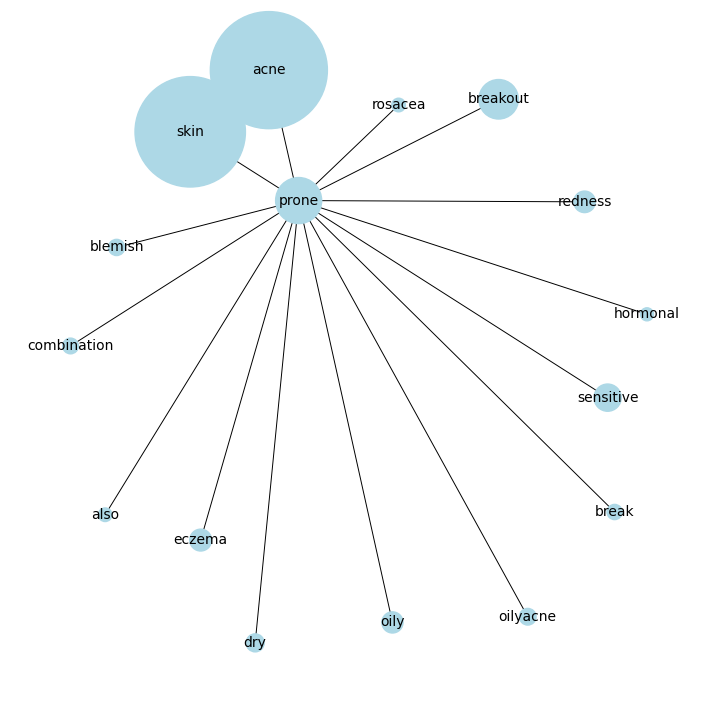

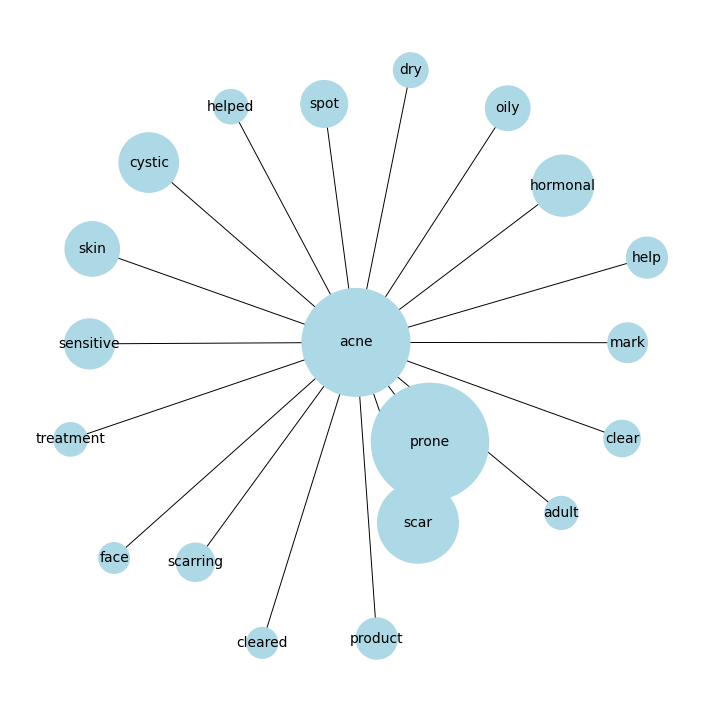

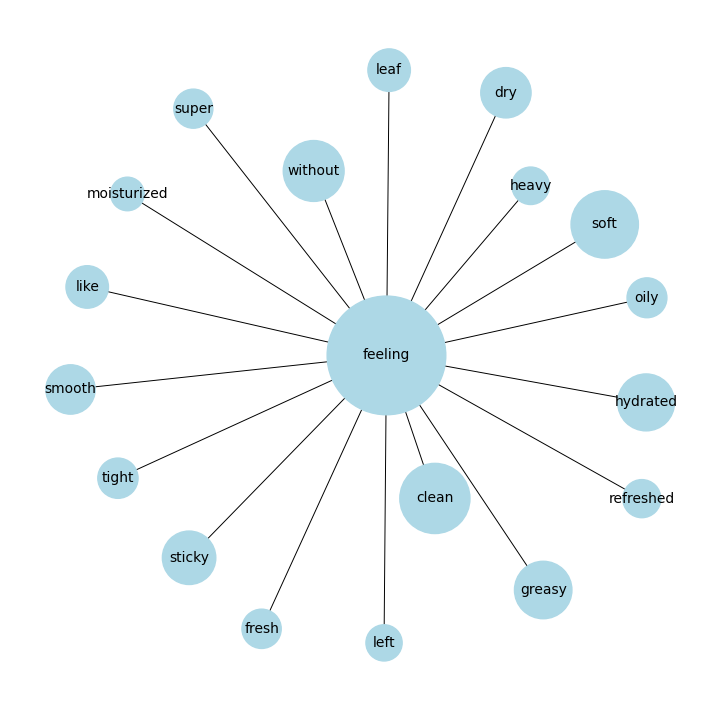

In [ ]:
# Visualize bigrams
def draw_network(key_word: str, lst_start: int, lst_end: int, 
                 spring_k=7, nsize_1=8, nsize_2=100):
    """Returns a network graph with the keyword in the center"""

    # Create a list of bigrams for the keyword
    merged_dict = defaultdict(int)
    for bigram, count in bigrams_sorted:
        if key_word in bigram:
            if bigram[0].startswith(key_word):
                key = bigram
            else:
                key = (bigram[1], bigram[0])
            merged_dict[key] += count
    bigram_lst = sorted(merged_dict.items(), key=lambda x: x[1], reverse=True)[lst_start:lst_end]


    # Build a network graph
    G = nx.Graph()
    fig, ax = plt.subplots(figsize=(9, 9))
    plt.axis('off')

    # Set the sizes and positions of the nodes
    node_sizes = {key_word: 500}
    for edge, size in bigram_lst:
        node1, node2 = edge
        G.add_edge(node1, node2, weight=size)
        node_sizes[node1] = node_sizes[node2] = size
    pos = nx.spring_layout(G, k=spring_k)
    nsize_lst = [node_sizes[v] * nsize_1 
                 if v != key_word 
                 else node_sizes[v] * nsize_2 
                 for v in node_sizes]
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', ax=ax, node_size=nsize_lst)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, width=0.7);


draw_network('skin', 0, 14, spring_k=15, nsize_1=2, nsize_2=10)
draw_network('sensitive', 1, 12)
draw_network('dry', 1, 17)
draw_network('prone', 0, 15, spring_k=7.43)
draw_network('acne', 0, 19, spring_k=7.43)
draw_network('feeling', 2, 20)
# draw_network('feel', 2, 14, spring_k=1, nsize_1=2, nsize_2=10)

What we can conclude from looking at the visualization data:
- dryness and skin sensitivity are the most common problems among customers. There is also mention of skin types
- we can identify a number of problems that the skin is prone to, such as acne, breakouts, and more narrowly focused clusters
- the most frequently mentioned acne companions are scars, cystic and hormonal acne type, spots and other
- feeling moisturized, soft and clean customers mention most often

These visualizations are only part of the possibilities. You can do similar research on narrower samples by category, brand, or time frame. Such data allows you to look deeper into customer problems and trace hidden trends. Ultimately, it's designed to help businesses adjust strategies and make data-driven decisions.

## Trigrams

Now, let's look at combinations of three words (trigrams). Yes, we can continue to increase the size of the word group further, but as a rule it is optimal to stop at a group of the size of three words.

Let's build a visualization of the most common trigrams:

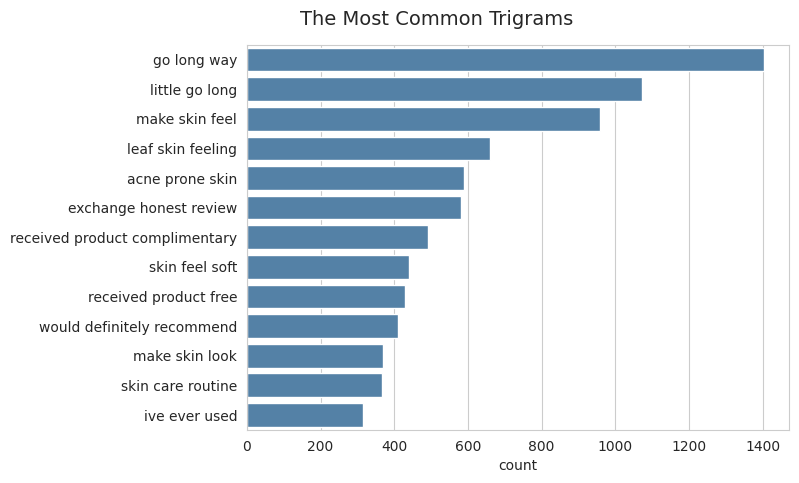

In [ ]:
# Create sorted list of all trigrams
trigrams = Counter()
for phrase in df['NLTK_text']:
    trigrams.update(nltk.trigrams(phrase))
trigrams_sorted = sorted(trigrams.items(), key=operator.itemgetter(1), reverse=True)

# Create dataframe fromt the most common trigrams
trigrams_df = pd.DataFrame(trigrams_sorted[:13], columns=['trigram', 'count'])

# Draw a barplot 
plt.figure(figsize=(7, 5))
sns.set_style('whitegrid')
sns.barplot(x='count', color='steelblue',
            y=[' '.join(trigram) for trigram in trigrams_df['trigram']], 
            data=trigrams_df)
plt.xlabel('count')
plt.title('The Most Common Trigrams', fontsize=14, y=1.03, x=0.35);

Here we see the most frequent mentions of time duration, mentions of skin feeling, an acne problem already encountered, and another interesting observation. Here we can see mentions of getting the product in exchange for an honest review and getting the product complimentary, etc. In my opinion, it is good that the text explicitly mentions such things, it allows customers to maintain trust in the products and brands.


Finally, let's look at an example of using the n-gram in a sample of interest - **negative reviews**. The most frequent trigrams in negative reviews:

In [ ]:
trigrams = Counter()
neg_df = df[df['true_sentiment'] == 'negative']
for phrase in neg_df['NLTK_text']:
    trigrams.update(nltk.trigrams(phrase))
trigrams_sorted = sorted(trigrams.items(), key=operator.itemgetter(1), reverse=True)
trigrams_sorted[:20]

[(('dont', 'waste', 'money'), 82),
 (('really', 'wanted', 'love'), 75),
 (('acne', 'prone', 'skin'), 69),
 (('wanted', 'love', 'product'), 66),
 (('really', 'wanted', 'like'), 55),
 (('made', 'skin', 'feel'), 39),
 (('dont', 'sensitive', 'skin'), 34),
 (('make', 'skin', 'feel'), 34),
 (('left', 'skin', 'feeling'), 34),
 (('didnt', 'notice', 'difference'), 31),
 (('didnt', 'feel', 'like'), 27),
 (('high', 'hope', 'product'), 25),
 (('really', 'excited', 'try'), 25),
 (('dry', 'sensitive', 'skin'), 25),
 (('would', 'recommend', 'product'), 24),
 (('received', 'product', 'free'), 24),
 (('ive', 'using', 'product'), 23),
 (('go', 'long', 'way'), 23),
 (('excited', 'try', 'product'), 23),
 (('wanted', 'like', 'product'), 22)]

We can see that most often users say 'don not waste money', as well as phrases that cover unmet expectations and unpleasant feelings. We can see that people with acne-prone and sensitive skin were more likely than others to be dissatisfied with the products.

# Sentiment prediction

One common tasks for NLP is sentiment prediction. By correctly predicting, for example, negative reviews, it is possible to react to them promptly to retain customer loyalty, eliminate the identified problems and improve products or services accordingly. Technically, this problem boils down to the problem of classification, and in this case, multiclass classification.

As we know from our earlier analysis, the dataset has a class imbalance and is quite large:

In [ ]:
# Original dataframe size
df.shape

(49918, 6)

Further steps for preparing dataset for building models:
- reduce dataset size  
- take a balanced sample from the dataset
- use TF-IDF vectorizer (Term Frequency - Inverse Document Frequency) to convert a collection of reviews to a matrix of TF-IDF features

In this case I will use random undersampling technique because it is a simple and effective way to address class imbalance, although it does not take into account the proportion of the classes in the original dataset. Of course it is good practice to use combination of oversampling and undersampling methods to increase model performance. Here, after some experiments in turned out the simple technique get quite good results.

In [ ]:
# Get a smaller representative sample of data
sample_size = 4000
df_sample = (df[['lemma_text', 'true_sentiment']]
                .groupby('true_sentiment')
                .apply(lambda x: x.sample(n=sample_size, replace=True))
                .reset_index(drop=True))

# Use TFID vectorizer and split data into training and test sets
tfid = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X = tfid.fit_transform(df_sample['lemma_text'])
y = df_sample['true_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

# Show new sample and train/test set sizes
print('New sample full size:', df_sample.shape)
print('Train set size:', y_train.shape[0])
print('Test set size:', y_test.shape[0])

New sample full size: (12000, 2)
Train set size: 9600
Test set size: 2400


In [ ]:
# Check sentiment distribution in new sample
df_sample['true_sentiment'].value_counts()

negative    4000
neutral     4000
positive    4000
Name: true_sentiment, dtype: int64

Now let's select the model that shows the best results

In [ ]:
# Save TF-ID in the pickle file for reuse in the future
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

# Select models
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

# Create list of estimated accuracy scores for each model
accuracy = []
for model in models:
    cross_val = cross_val_score(model, X_train, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

# List of all trained model names
model_names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
               'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

# Create dataframe with accuracy score for each model
acc_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy})
acc_df

,Model,Accuracy
0,DecisionTreeClassifier,0.684479
1,RandomForestClassifier,0.793958
2,SVC,0.816042
3,LogisticRegression,0.761979
4,KNeighborsClassifier,0.506146
5,BernoulliNB,0.699479


As we can see, the best-performing model is SVC (C-Support Vector Classification). Next, I will adjust the hyperparameters of the model to improve the performance. 

SVC model has three main hyperparameters (see [here](https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/) visually): 
- **C** (regularisation): penalty parameter, how much error is bearable. When C is high it will classify all the data points correctly, also there is a chance to overfit and vice versa
- **gamma**: how far influences the calculation of plausible line of separation.High gamma - only near points are considered, low gamma - far away point also concidered
- **kernel**: the best way how to separate complex data points that are not linearly separable. Here we choose between using gaussian rbf, sigmoid or polynomial kernel

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

clf = GridSearchCV(SVC(random_state=42), param_grid, cv=5, n_jobs=-1, refit=True, verbose=2)
best_model = clf.fit(X_train, y_train)

print(best_model.best_estimator_)
print("The mean accuracy of the model is:", best_model.score(X_test,y_test))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
SVC(C=10, gamma=1, random_state=42)
The mean accuracy of the model is: 0.8183333333333334


The selection of hyperparameters gave an insignificant increase, but I am sure that it is possible to achieve better results with continued work. Let's use these parameters to train the main model and save it to the pickle file:

In [ ]:
# Train the SVC model and write it to a file
log = SVC(C=10, gamma=1, random_state=42, probability=True)
log.fit(X_train, y_train)
pred = log.predict(X_test)

pickle.dump(log, open('ml_model.pkl', 'wb'))

Let's check how the resulting model copes with the prediction by writing a test review:

In [ ]:
# Load the trained ml model and TF-IDF vectorizer from files
ml = pickle.load(open('ml_model.pkl', 'rb'))
tfidf = pickle.load(open('tfidf.pkl', 'rb'))

# Get a prediction for a test review
def ml_predict(text: str) -> tuple:
    """Returns a tuple of two values: the predicted class and 
    the probability score that the review belongs to the predicted class"""

    # Preprocess the input text and transform it using the TF-IDF
    tfid_matrix = tfidf.transform([clean_text(text)])

    # Predict the probability of each class based on the transformed data
    pred_proba = ml.predict_proba(tfid_matrix)

    # Get the class with the highest predicted probability and its associated score
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]
    
    return pred, pred_proba[0][idx]


ml_predict('Do not waste your money! This product did nothing for me.')

('negative', 0.9945192252024401)

As we can see the model correctly, with a high probability (0.99) classified this review as 'negative'.

Let's also analyze the errors in this model by looking at the classification report and drawing a confusion matrix:




Classification report:
               precision    recall  f1-score   support

    negative       0.80      0.82      0.81       828
     neutral       0.76      0.77      0.76       789
    positive       0.87      0.83      0.85       783

    accuracy                           0.81      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400



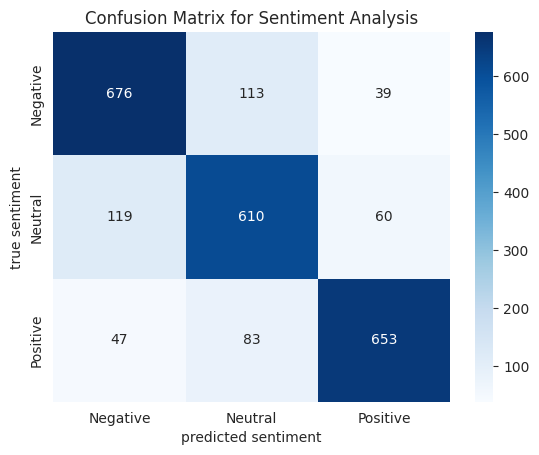

In [ ]:
# Print classification report
print('Classification report:\n', classification_report(y_test, pred))

# Create heatmap
cm = confusion_matrix(y_test, pred)
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted sentiment')
plt.ylabel('true sentiment')
plt.title('Confusion Matrix for Sentiment Analysis');

I see that the model does a good job of predicting negative and positive reviews, but shows a slightly worse performance when classifying neutral ones. For all metrics, we see a fairly even performance without any bias. In general, the worst result in predicting neutral reviews is acceptable, because I mentioned earlier that the inclusion of the 'neutral' class is conditional.

# Topic modeling

The latest technique in this notebook is **topic modeling**. This is an unsupervised machine learning technique that automatically analyzes textual data identifying clusters of words (topics). This is used to identify hidden themes or patterns and can be useful for tasks such as information retrieval, text classification, and content recommendations.

For this task, I will use the open-source library 'pyLDAvis':

In [ ]:
# Preprocess review text for further modeling
reviews = [row.split() for row in df['lemma_text']]

# Create a dictionary and filter out words that occur less than 10 reviews, 
# or more than 20% of the reviews
dictionary = corpora.Dictionary(reviews)
dictionary.filter_extremes(no_below=10, no_above=0.2)

# Sparse vectors of (word ID, frequency count) tuples for each review
corpus = [dictionary.doc2bow(review) for review in reviews]

# Train an LDA model on the corpus
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5)

# Print the topics and the top words for each topic
for topic in lda_model.show_topics(num_topics=5, num_words=7, formatted=False):
    print(f"""Topic {topic[0] + 1} top words: {[w[0] for w in topic[1]]}\n""")

Topic 1 top words: ['mask', 'look', 'one', 'ive', 'pore', 'used', 'amazing']

Topic 2 top words: ['cleanser', 'one', 'would', 'size', 'clean', 'acne', 'sensitive']

Topic 3 top words: ['smell', 'makeup', 'doesnt', 'dry', 'great', 'make', 'oily']

Topic 4 top words: ['ive', 'week', 'see', 'difference', 'used', 'day', 'result']

Topic 5 top words: ['cream', 'eye', 'serum', 'moisturizer', 'dry', 'great', 'night']



The challenge in topic modeling is to find the optimal number of topics so that they are far apart and cover all the major topics at the same time. I came to the conclusion experimentally that in this case 5 is the most optimal number of topics.

Let's make a interactive visual inspection of topic models:

In [ ]:
# Visualize 5 topics using pyLDAvis
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

The image below is a screenshot of the visualization (for GitHub, since it does not display correctly)

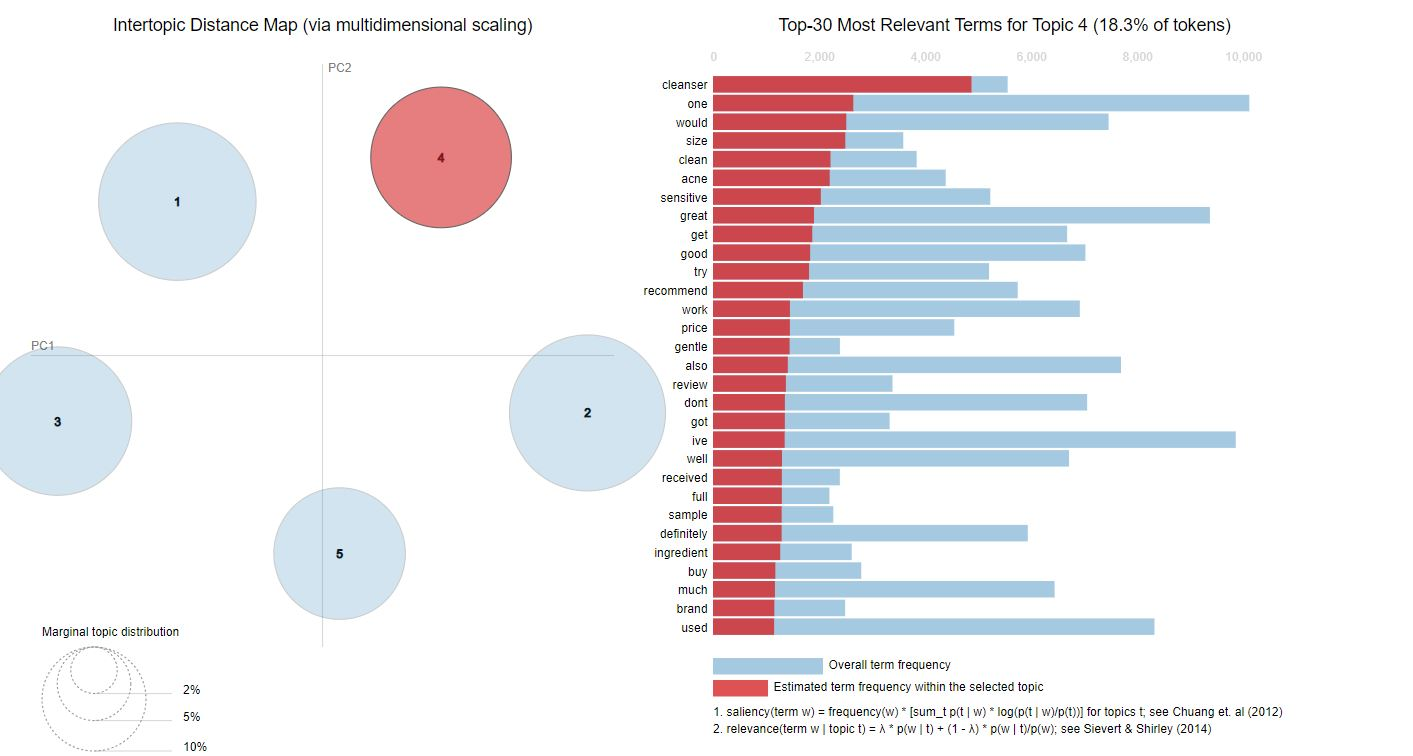

These topics cover five main product types, like cleanser, lip, mask, etc. 

On this interactive visualization we can see common and different words for these topics, for example:
- customers with acne problems (topic 2) mention duration/time and 'difference' much more frequently than customers from the 'cleanser' category (topic 4)
- at the same time customers from the 'cleanser' category (topic 4) much more frequently mention 'ingredient' and like customers from the 'moisturizer' category(topic 3)

You can continue to research words by generated topics and discover hidden trends or characteristics of each group (topic), thereby expanding your understanding of customer interests and concerns.

# Summary


In conclusion, this notebook demonstrated how NLP techniques can provide businesses with valuable insights from customer reviews. By analyzing a dataset of skin care product reviews, I showed how examining distributions, n-grams, sentiment analysis, and topic modeling can reveal trends and patterns to inform decision-making and strategy development.

The following areas were touched upon in this notebook:
- used supervised and unsupervised machine learning models
- solved the problem of preprocessing text using various popular approaches
- used techniques for dimensionality reduction and data balancing
- all results were visualized using a variety of tools

**Possible improvements and further work**

- use boosting or gradient boosting models, sophisticated error measurement methods (such as ROC-AUC), and nuanced techniques for class imbalances to enhance the current model
- develop an NLP-based text recommendation system to improve user engagement
- create an automatic report generation system using collected reviews to save time and provide quicker insights